# 特徴量の重要度

## 利用場面
 - ドメイン知識に沿ったモデルかのデバッグ
 - 重要度が高い説明変数と低い説明変数で想定外のバグや外れ値がないかの確認
 - KPI改善に向けた有効変数の選定

In [23]:
import sys
import warnings
import joblib
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [17]:
warnings.simplefilter("ignore")

# シミュレーションデータ作成

In [8]:
def generate_simulation_data(N, beta, mu, Sigma):
    """  
        線形のシミュレーションデータを生成し、訓練データとテストデータに分割
    
        Args:
            N：インスタンス数（データ数）
            beta:各特徴量の傾き
            mu:各特徴量は他変量正規分布で生成。その平均
            Sigma：各特徴量は他変量正規分布で生成。その分散共分散行列
    
    """
    
    # 他変量正規分布からデータを生成
    X = np.random.multivariate_normal(mu, Sigma, N)
    
    # ノイズは平均０、標準偏差0.1
    epsilon = np.random.normal(0, 0.1, N)
    
    # 特徴量とノイズの線形和で目的変数を作成
    y = X @ beta + epsilon
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# シミュレーションデータの設定
N = 1000
J = 3
mu = np.zeros(J)
Sigma = np.array([[1,0,0], [0,1,0], [0,0,1]])
beta = np.array([0,1,2])

# シミュレーションデータの作成
X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

# 線形回帰の特徴量重要度

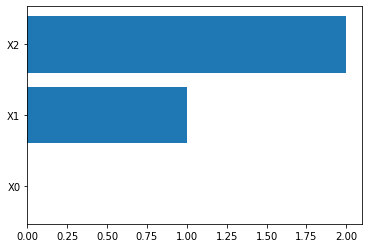

In [20]:
def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    """ 回帰係数の大きさを棒グラフで表示"""
    
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,None))
    fig.suptitle(title)
    
    fig.show()
    
# 線形回帰の学習
lm = LinearRegression()
lm.fit(X_train, y_train)

# 回帰係数の可視化
var_names = [f"X{j}" for j in range(J)]
plot_bar(var_names, lm.coef_)

# 機械学習での特徴量重要度

## アイデア（予測誤差を使用したアプローチ）
1. 一つ一つの特徴量が「使えない」場合の予測誤差を計算
2. 「使える」場合の予測誤差との差分を見る

## Permutation Feature Importance (PFI）
　対象の特徴量をシャッフルして「使えない」状況を作り出す
 
手順
1. 学習
2. 加工なしのテストデータで予測（基準値）
3. テストデータのうち、１つの特徴量をシャッフルして予測
4. 2と3の予測誤差の差分を見る
5. 2〜４を特徴量分だけ繰り返す
6. 特徴量の重要度を可視化して比較

In [64]:
@dataclass
class PermutationFeatureImportance:
    """
        Permutation Feature Importance(PFI）
        
        Args:
            model : 学習済みモデル
            X : 特徴量
            y : 目的変数
            var_names : 特徴量の名前
    """
    
    def __init__(self, model, X:np.ndarray, y:np.ndarray, var_names:list[str]):
        self.model = model
        self.X = X
        self.y = y
        self.var_names = var_names
        self.baseline = self.__post_init__()
        
    def __post_init__(self)-> None:
        """ 基準値（全特徴量を使った予測誤差）"""
        return mean_squared_error(self.y, self.model.predict(self.X), squared=False)
        
    def _permutation_metrics(self, idx_to_permute:int) ->float:
        """
            ある特徴量の値をシャッフルしたときの予測誤差
            
            Args:
                idx_to_permute
        """
        
        X_permuted = self.X.copy()
        
        X_permuted[:,idx_to_permute] = np.random.permutation(X_permuted[:,idx_to_permute])
        y_pred = self.model.predict(X_permuted)
        
        return mean_squared_error(self.y, y_pred, squared=False)
    
    def permutation_feature_importance(self, n_shuffle:int=10) -> None:
        """ 
            PFIを求める
        
            Args:
                n_shuffle:シャッフルする回数（シャッフルした予測誤差を安定させるため）　。デフォルト10
        """
        J = self.X.shape[1] # 特徴量の数
        
        # 特徴量分のPFIを求める
        # n_shuffle分だけ回して、結果を安定させる
        metrics_permuted = [
            np.mean([self._permutation_metrics(j) for r in range(n_shuffle)])
            for j in range(J)
        ]
        
        df_feature_importance = pd.DataFrame(
            data = {
                "var_names":self.var_names,
                "baseline":self.baseline,
                "permutation":metrics_permuted,
                "difference":metrics_permuted - self.baseline,
                "ratio":metrics_permuted / self.baseline
            }
        )
        
        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False)
        
    def plot(self, importance_type:str="difference") -> None:
        """ 可視化"""
        
        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance['var_names'],
            self.feature_importance[importance_type],
            label=f"baseline:{self.baseline:.2f}")
        ax.set(xlabel=importance_type, ylabel=None)
        ax.invert_yaxis()
        ax.legend(loc="lower right")
        fig.suptitle(f"Permutation Feature Importance({importance_type})")
        fig.show()

In [65]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

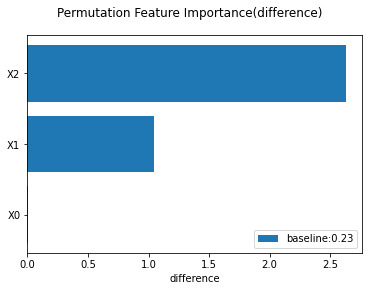

In [66]:
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)
pfi.permutation_feature_importance()
pfi.plot()

# Grouped Permutation Feature Importance (GPFI)

特徴量同士が相関していたり、似ている意味の時にまとめてPFIを求めるアイデア<br>
使う場面はこんな感じ
 - 特徴量同士に相関あり
 - カテゴリカル変数をOneHotEncodingして、複数列がある場合
 - まとめた方が解釈性の向上が見込める（例：緯度経度）


In [104]:
class GroupedPermutationFeatureImportance(PermutationFeatureImportance):
    """ Grouped PFI"""
    
    def _permutation_metrics(self, var_names_to_permute:list[str]) ->float:
        """ 特徴量グループの値をシャッフルした時に予測誤差を求める"""
        
        X_permuted = self.X.copy()
        
        # 特徴量グループのindexを保持
        idx_to_permute = [
            self.var_names.index(n) for n in var_names_to_permute
        ]
        
        # 特徴量グループに分けて、シャッフルして予測
        X_permuted[:, idx_to_permute] = np.random.permutation(X_permuted[:, idx_to_permute])
        y_pred = self.model.predict(X_permuted)
        
        return mean_squared_error(self.y, y_pred, squared=False)
    
    def permutation_feature_importance(self, 
                                       var_groups:list[list[str]]=None, 
                                       n_shuffle:int=10
                                      )->None:
        """ GPFIを求める
        
        Args:
            var_groups:
                グループ化された特徴量のリスト
            n_shuffle:
                シャッフル回数
        """
        
        if var_groups is None:
            var_groups = [ [j] for j in self.var_names] 
        
        metrics_permuted = [
            np.mean([self._permutation_metrics(g) for n in range(n_shuffle)])
            for g in var_groups]
        
        df_feature_importance = pd.DataFrame(
            data={
                "var_names": ["+".join(j) for j in var_groups],
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline,
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

In [105]:
X_train2 = np.concatenate([X_train, X_train[:,[2]]],axis=1)

In [106]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train2, y_train)

RandomForestRegressor(random_state=42)

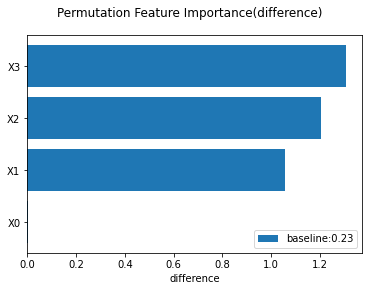

In [113]:
X_test2 = np.concatenate([X_test, X_test[:,[2]]], axis=1)

gpfi = GroupedPermutationFeatureImportance(rf, X_test2, y_test, var_names=["X0", "X1", "X2", "X3"])

# var_groupsを指定しなければ通常のPFIが計算される
gpfi.permutation_feature_importance()

# 可視化
gpfi.plot()

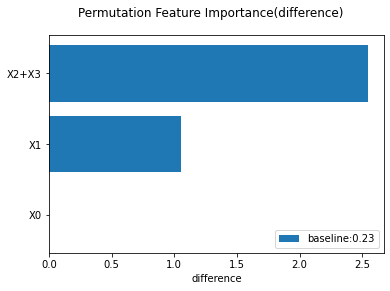

In [115]:
# var_groupsを指定しなければ通常のPFIが計算される
gpfi.permutation_feature_importance(var_groups=[["X0"], ["X1"], ["X2", "X3"]])

# 可視化
gpfi.plot()